In [ ]:
!git clone https://github.com/rinziv/XAI_lib_HAI-net_Tutorial.git

Cloning into 'XAI_lib_HAI-net_Tutorial'...
remote: Enumerating objects: 337, done.
remote: Counting objects: 100% (337/337), done.
remote: Compressing objects: 100% (271/271), done.
remote: Total 337 (delta 63), reused 327 (delta 53), pack-reused 0
Receiving objects: 100% (337/337), 229.10 MiB | 29.04 MiB/s, done.
Resolving deltas: 100% (63/63), done.
Checking out files: 100% (274/274), done.


In [ ]:
cd XAI_lib_HAI-net_Tutorial

/content/XAI_lib_HAI-net_Tutorial


# Examples of XAI-Lib Usage for MNIST data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
# Load Dataset
from tensorflow.keras.datasets import mnist
(MNIST_x_data_train, MNIST_y_data_train), (MNIST_x_data_test, MNIST_y_data_test) = mnist.load_data()

In [3]:
# Load the model
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = torch.nn.functional.softmax(self.linear_block(x),dim=1)
        
        return x
MNIST_CNN = Net()
MNIST_CNN.load_state_dict(torch.load('./models/MNIST_Pytorch_CNN.pt',map_location=torch.device('cpu')))
MNIST_CNN.eval()

Net(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6272, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

# The Sample

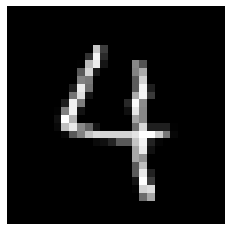

In [4]:
idx = 24
image = MNIST_x_data_test[idx]
plt.imshow(image,cmap='gray')
plt.axis('off');

# ABELE

In order to work ABELE needs a Test Set and an autoencoder trained on that

### 1) Autoencoder Training

Here we have a script to guide the user to the creation and the training of the autoencoder. 
If you want to use your own, you need to implement an autoencoder class with these funtioncs inside:
- self.encode: take the image as input and return the latent space vector
- self.decode: take a vector as input and return the reconstructed image
- self.latent_dim: int representing the number of dimensions of the latent space

#### Custom autoencoder model example

In [5]:
import sys
import os
from externals.ABELE.experiments.exputil import get_autoencoder
from externals.ABELE.experiments.exputil import get_dataset
import shap
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

#disable eager execution for faster training time
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# The dataset to use for training
# if you prefer to use yours load the data in two vector X_data and Y_data, set dataset variable to a custom name and custom_dataset to True
dataset = 'custom'

# Load Data
(_, _), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()
X_test = (X_test/255).reshape(-1,28,28,1)

# Name of autoencoder to save the weights ['aae','vae']
ae_name = 'aae'

# This script will save the models weights in the folder ./path/models/abele/dataset/ae_name
path = './'
path_aemodels = path + 'models/abele/%s/%s/' % (dataset,ae_name)
if not os.path.exists(path_aemodels):
    os.makedirs(path_aemodels)

# HYPER-PARAMETERS
#define the epochs and the batch size for which the autoencoder will be trained
epochs = 2000
batch_size = 64
#Print training summary every sample_interval step
sample_interval = 50

"""
 Get_autoencoder create the autoencoder class to train
 Arguments: 
    X: dataset to use to train the ae 
    ae_name: type of the autoencoder to train, only adversarial autoencoder (aae) and variational autoencoder (vae) are supported
    path_aemodels: path where to save the weights
    dataset: name of the dataset to use
    OPTIONAL:
    latent_dim: latent space dimension (only use if dataset is custom)
    hidden_dim: hidden dimension of the autoencoders layers (ex: 1024 will create two layers of 1024 hidden units) (only use if dataset is custom)
    num_filters: number of filter to use in the convolutional layers (only use if dataset is custom)
"""
ae = get_autoencoder(X_test, ae_name, path_aemodels, dataset, latent_dim=10, hidden_dim=128, num_filters=16, use_rgb=False)
""" Fit method
 Arguments: 
    X: Dataset to use to train the ae
    epochs: Epochs to train
    batch_size
    sample interval (see before)
"""
ae.fit(X_test, epochs=epochs, batch_size=batch_size, sample_interval=sample_interval)
# save the weights in the path specified before
ae.save_model()
# save some sample images of the final epoch to test if the autoencoder has trained correctly
ae.sample_images(epochs)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 9,729
Trainable params: 9,729
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
__________________________________________________________________________________________________
Laye

2022-02-28 09:57:18.279516: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 0/2000, 1.00 [D loss: 0.695832, acc: 52.34%] [G loss: 0.231449, mse: 0.231004]
Epoch 50/2000, 0.04 [D loss: 0.317273, acc: 88.28%] [G loss: 0.074925, mse: 0.071505]
Epoch 100/2000, 0.04 [D loss: 0.461467, acc: 72.66%] [G loss: 0.070880, mse: 0.068284]
Epoch 150/2000, 0.04 [D loss: 0.460890, acc: 78.12%] [G loss: 0.064784, mse: 0.062751]
Epoch 200/2000, 0.04 [D loss: 0.479395, acc: 81.25%] [G loss: 0.056885, mse: 0.055302]
Epoch 250/2000, 0.04 [D loss: 0.538648, acc: 71.88%] [G loss: 0.041780, mse: 0.040261]
Epoch 300/2000, 0.04 [D loss: 0.384427, acc: 92.19%] [G loss: 0.037112, mse: 0.035359]
Epoch 350/2000, 0.04 [D loss: 0.326780, acc: 93.75%] [G loss: 0.029226, mse: 0.027396]
Epoch 400/2000, 0.04 [D loss: 0.321972, acc: 93.75%] [G loss: 0.028026, mse: 0.026219]
Epoch 450/2000, 0.04 [D loss: 0.382580, acc: 89.06%] [G loss: 0.029451, mse: 0.027960]
Epoch 500/2000, 0.04 [D loss: 0.382102, acc: 87.50%] [G loss: 0.026071, mse: 0.024598]
Epoch 550/2000, 0.04 [D loss: 0.499542, acc: 7

In [9]:
ae.__dict__

{'shape': (28, 28, 1),
 'input_dim': 784,
 'latent_dim': 10,
 'hidden_dim': 128,
 'alpha': 0.2,
 'verbose': True,
 'store_intermediate': True,
 'save_graph': False,
 'path': './models/abele/custom/aae/',
 'name': 'aae_custom_10',
 'encoder': <keras.engine.functional.Functional at 0x7fe728127790>,
 'decoder': <keras.engine.functional.Functional at 0x7fe7486e8070>,
 'autoencoder': <keras.engine.functional.Functional at 0x7fe728058c70>,
 'discriminator': <keras.engine.functional.Functional at 0x7fe73b40e400>,
 'generator': None,
 'use_rgb': False,
 'num_filters': 32,
 'conv_dim': TensorShape([14, 14, 32])}

In [14]:
ae.encode

<bound method Autoencoder.encode of <externals.ABELE.autoencoders.adversarial.Image_AdversarialAutoencoder object at 0x7fe77f429850>>

./models/abele/custom/aae/
custom
generating neighborhood - hrg
gen	nevals	avg     	min     	max     
0  	250   	0.496654	0.496654	0.496654
1  	145   	0.54178 	0.11501 	0.991163
2  	162   	0.650125	0.20239 	0.993298
3  	125   	0.842789	0.257448	0.993298
4  	155   	0.920559	0.241609	0.993306
5  	154   	0.929829	0.166677	0.993306
6  	127   	0.949359	0.217098	0.993306
7  	141   	0.929717	0.152925	0.993306
8  	129   	0.936843	0.31149 	0.993306
9  	154   	0.917172	0.334342	0.993306
10 	143   	0.934204	0.1259  	0.993306
11 	156   	0.909883	0.15621 	0.993306
12 	147   	0.934008	0.196246	0.993306
13 	154   	0.933711	0.325197	0.993306
14 	139   	0.943742	0.164501	0.993306
15 	140   	0.922864	0.232102	0.993306
16 	156   	0.941807	0.308765	0.993306
17 	161   	0.924797	0.0567546	0.993306
18 	166   	0.915068	0.122795 	0.993306
19 	151   	0.924286	0.289667 	0.993306
20 	160   	0.926573	0.313448 	0.993306
21 	125   	0.946051	0.335738 	0.993306
22 	151   	0.946579	0.345524 	0.993306
23 	154   	0.93448

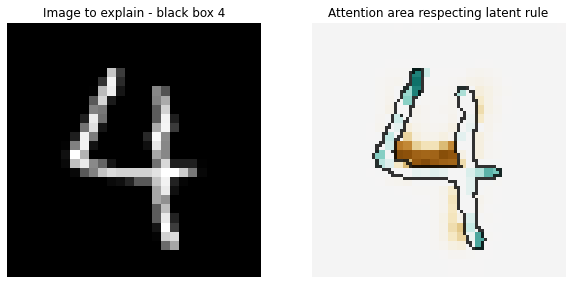

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from skimage.color import gray2rgb, rgb2gray
from skimage import feature, transform
#disable eager execution in tensorflow 2.x for faster training time
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from externals.ABELE.ilore.ilorem import ILOREM
from externals.ABELE.ilore.util import neuclidean

from externals.ABELE.experiments.exputil import get_dataset
from externals.ABELE.experiments.exputil import get_autoencoder

import warnings
warnings.filterwarnings('ignore')

random_state = 0
dataset = 'custom' 
black_box = 'AB' #agnostic Black Box

# load autoencoder and black box
ae_name = 'aae' 
path = './' 
path_aemodels = path + 'models/abele/%s/%s/' % (dataset, ae_name)
bb = tf.keras.models.load_model("./models/cnn_simple_mnist_no_pickle")
# defining a functions for bb to return the class index value
def bb_predict(X):
    X = X.astype(float)
    Y = bb.predict(X)   
    return np.argmax(Y, axis=1)

# load data
dataset = 'custom'
(_, _), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()
X_test = (X_test/255).reshape(-1,28,28,1)
use_rgb=False

print(path_aemodels)
print(dataset)
# load auto encoder
ae = get_autoencoder(X_test, ae_name, path_aemodels, dataset, latent_dim=10, hidden_dim=128, num_filters=16, use_rgb=use_rgb)
ae.load_model()

class_name = 'class'
class_values = ['%s' % i for i in range(len(np.unique(Y_test)))]

# index Image 2 Explain
img = X_test[idx]
# time
start = time.time()
# create explainer
"""
Arguments:
    bb_predict: function which return the prediction of the blackbox in form index of the class 
    class_name: name of the class used when printing rules (class_name: class_value)
    class_values: list of names of the classes (class_name: class_value)
    neigh_type: select the nighbourhood type,
                supportecd types:
                'gnt' : genetic
                'rnd' : random
                'hrg' : hybrid-random-genetic
                'gntp': genetic probabilistic
                'hrgp': hybrid probabilistic
    ocr: [0.1] other class values, ratio of other class from the one predicted in the neighbourhood
    kernel: [None] Kernel to weights the point in the nieghbourhood
    kernel_width : [None]  
    autoencoder: Autoencoder to generate the latent space points
    use_rgb = [True] Set to True if the input images are rgb, False for grayscale
    filter_crules: [None] if True Prototypes are checked by the black box to be the same class of the query image
    random_state: set the seed of the random state
    verbose: True if you want to print more informations
    NEIGHBOURHOOD PARAMETERS: the following parameters are Neighbourhood specific and may not apply to all of the neighbourhood types
        valid_thr: [0.5] threshold to change class in the autoencoder disciminator
        alpha1: [0.5] weight of the feature similarity of the neighbourhood points
        alpha2: [0.5] weight of the target similarity of the neighbourhood points
        ngen: [100] number of generations of the genetic algorithm
        mutpb: [0.2] The probability of mutating an individual in the genetic algorithm
        cxpb: [0.5] The probability of mating two individuals in the genetic algorithm
        tournsize: [3] number of tournaments in the genetic algorithm
        hallooffame_ratio: [0.1] Fraction of exemplars to keep at every genetic generation
"""
explainer = ILOREM(bb_predict, 
                   class_name, 
                   class_values, 
                   neigh_type='hrg',
                   ocr=0.1,
                   kernel_width=None, 
                   kernel=None, 
                   autoencoder=ae, 
                   use_rgb=use_rgb, 
                   filter_crules=True, 
                   random_state=random_state, 
                   verbose=True, 
                   valid_thr=0.5,
                   alpha1=0.5, 
                   alpha2=0.5,
                   metric=neuclidean, 
                   ngen=100, 
                   mutpb=0.2, 
                   cxpb=0.5, 
                   tournsize=3, 
                   halloffame_ratio=0.1)

"""
generate an explanation for a given image
Arguments:
    img: the image to explain
    num_samples: [1000] number of samples to generate with the neighbourhood algorithm
    use_weights: [True] if weights the points using distance
Return:
Explanation object compose by several things
    rstr: string describing the rule
    cstr: string describing the counterfactual rule
    bb_pred: black box prediction of the image
    dt_pred: decisoon tree prediction
    fidelity: fidelity between black box and the decision tree
    limg: latent space representation of the image
"""
exp = explainer.explain_instance(img, num_samples=1000, use_weights=True, metric=neuclidean)
# time
end = time.time()
print('--------------------------')
print('execution time: ',end - start,' sec')
print('e = {\n\tr = %s\n\tc = %s    \n}' % (exp.rstr(), exp.cstr()))
print('--------------------------')
print('bb prediction of reconstructed image: ',exp.bb_pred,'dt prediction: ',exp.dt_pred,'fidelity: ',exp.fidelity)
print('latent space representation: ',exp.limg)

"""
Arguments:
    features: [None] list of which feature of the latent space to use, If None use all
    samples: [10] number of prototype to use
Return the image and the difference between the prototypes
"""
img2show, mask = exp.get_image_rule(features=None, samples=400)

# Plot Script
F, ax = plt.subplots(1,2, figsize=(10,5))
if use_rgb:
    ax[0].imshow(img2show)
else:
    ax[0].imshow(img2show, cmap='gray')
bbo = bb_predict(np.array([img2show]))[0]
ax[0].set_title('Image to explain - black box %s' % bbo)
ax[0].axis('off')
dx, dy = 0.05, 0.05
xx = np.arange(0.0, img2show.shape[1], dx)
yy = np.arange(0.0, img2show.shape[0], dy)
xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
extent = xmin, xmax, ymin, ymax
cmap_xi = plt.get_cmap('Greys_r')
cmap_xi.set_bad(alpha=0)
# Compute edges (to overlay to heatmaps later)
percentile = 100
dilation = 3.0
alpha = 0.8
xi_greyscale = img2show if len(img2show.shape) == 2 else np.mean(img2show, axis=-1)
in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
edges = feature.canny(in_image_upscaled).astype(float)
edges[edges < 0.5] = np.nan
edges[:5, :] = np.nan
edges[-5:, :] = np.nan
edges[:, :5] = np.nan
edges[:, -5:] = np.nan
overlay = edges
ax[1].imshow(mask, extent=extent, cmap=plt.cm.BrBG, alpha=1, vmin=0, vmax=255)
ax[1].imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
ax[1].axis('off')
ax[1].set_title('Attention area respecting latent rule');

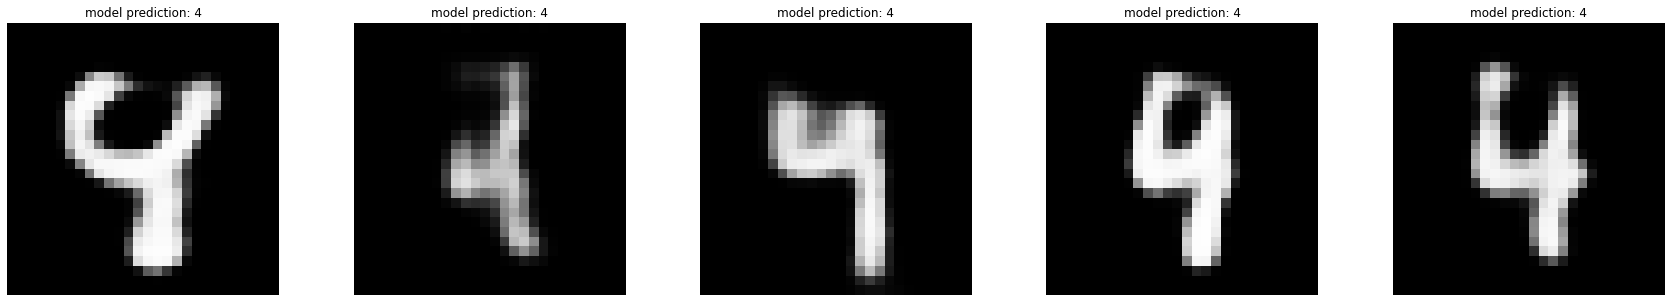

In [ ]:
"""
Return the prototypes images
Arguments:
    num_prototypes: [5] number of prototypes to return
    return_latent: [False] if True return latent representation
    return_diff: [False] If True return the difference with the query image
    features: [None] list of the features int he latent space to use, if none use all
"""
proto = exp.get_prototypes_respecting_rule(num_prototypes=5)

F, ax = plt.subplots(1,5,figsize=(30,5))
for i in range(5):
    ax[i].imshow(proto[i])
    ax[i].axis('off')
    ax[i].set_title('model prediction: '+str(bb_predict(rgb2gray(proto[0])[np.newaxis,:,:,np.newaxis])[0]))

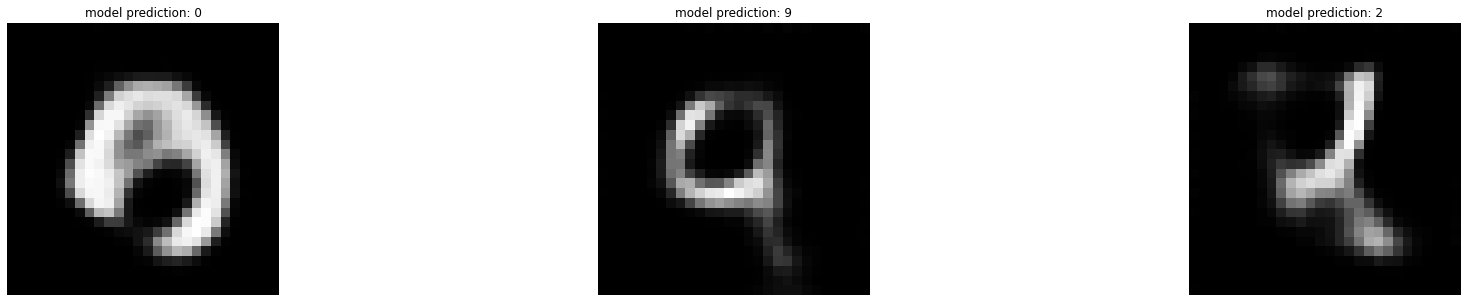

In [ ]:
"""
Return the couterfactuals satisfying the counterfactual rule
"""
counter = exp.get_counterfactual_prototypes()

F, ax = plt.subplots(1,len(counter),figsize=(30,5))
if len(counter)==0:
    print('no counterfactual found')
elif len(counter)==1:
    plt.imshow(counter[0]/255)
    plt.axis('off')
    plt.set_title('model prediction: '+str(bb_predict(counter[0])[0]))    
for i in range(len(counter)):
    ax[i].imshow(counter[i]/255)
    ax[i].axis('off')
    ax[i].set_title('model prediction: '+str(bb_predict(counter[i])[0]))